# Credit Default Prediction Using Machine Learning  
#### A full-cycle exploratory and predictive analysis  
**Author:** Shynggys Torez

## Problem Overview

This project aims to build a predictive model for determining the likelihood of a customer defaulting on their credit card payment next month. The dataset includes 30,000 records with demographic variables (such as age, sex, education, marriage), credit history, past bill amounts, and previous payment behavior.

The target variable is:
- `default.payment.next.month`: 1 means the customer **defaulted**, 0 means **paid successfully**.

We'll perform exploratory data analysis (EDA), visualize patterns, apply machine learning algorithms (Logistic Regression and XGBoost), and evaluate model performance using metrics like accuracy, confusion matrix, and ROC-AUC.

In [14]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

##Data Import and Preview

In this step, we load the dataset and preview the first few rows to understand its structure.

In [25]:
df = pd.read_csv(r"C:\Users\cheen\Downloads\UCI_Credit_Card.csv")

## Data Cleaning

In this step, I remove unnecessary columns (`ID`) and check for missing values to ensure the dataset is clean and ready for analysis.

In [28]:
# Drop the unnecessary ID column
df = df.drop(columns=['ID'])

# Check for missing values
missing_values = df.isnull().sum()

## Data Preprocessing

We loaded the dataset and removed the irrelevant ID column. No missing values were detected, so data is clean for further processing.

In [31]:
# Map categorical data to readable formats
df['SEX'] = df['SEX'].map({1: 'Male', 2: 'Female'})
df['EDUCATION'] = df['EDUCATION'].map({1: 'Graduate School', 2: 'University', 3: 'High School', 4: 'Others', 5: 'Others', 6: 'Others', 0: 'Others'})
df['MARRIAGE'] = df['MARRIAGE'].map({1: 'Married', 2: 'Single', 3: 'Others', 0: 'Others'})

## Detailed Exploratory Analysis by Categories

### Gender-wise Credit Default Analysis

This visualization shows the distribution of credit defaults by gender. It compares the number of male and female clients who defaulted (or did not) on their credit payments. From the chart, we observe that the number of female clients is higher overall, but the proportion of defaults is similar across genders. This can help in understanding whether gender has any visible influence on default behavior.

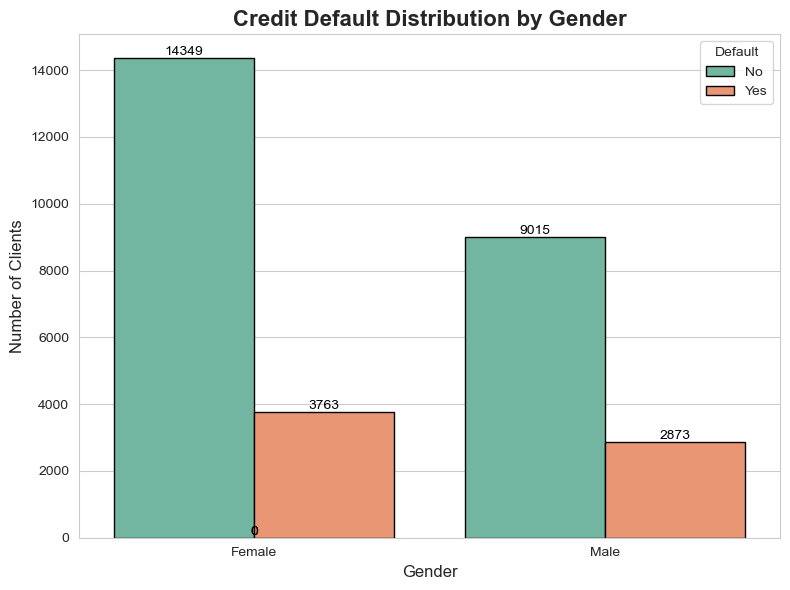

In [43]:
# Set figure size and clean style
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Create the count plot
ax = sns.countplot(
    x='SEX',
    hue='default.payment.next.month',
    data=df,
    palette='Set2',
    edgecolor='black'
)

# Add titles and labels
plt.title('Credit Default Distribution by Gender', fontsize=16, weight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Clients', fontsize=12)
plt.xticks([0, 1], ['Female', 'Male'])

# Format legend
plt.legend(title='Default', labels=['No', 'Yes'])

# Add count labels above bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()


The proportions of defaults are fairly similar across genders, suggesting no strong gender-based trend in this dataset.

### Age-wise Credit Default Distribution

This chart illustrates how credit default rates are distributed across different age groups. It helps us understand whether age is a significant factor in predicting credit default.


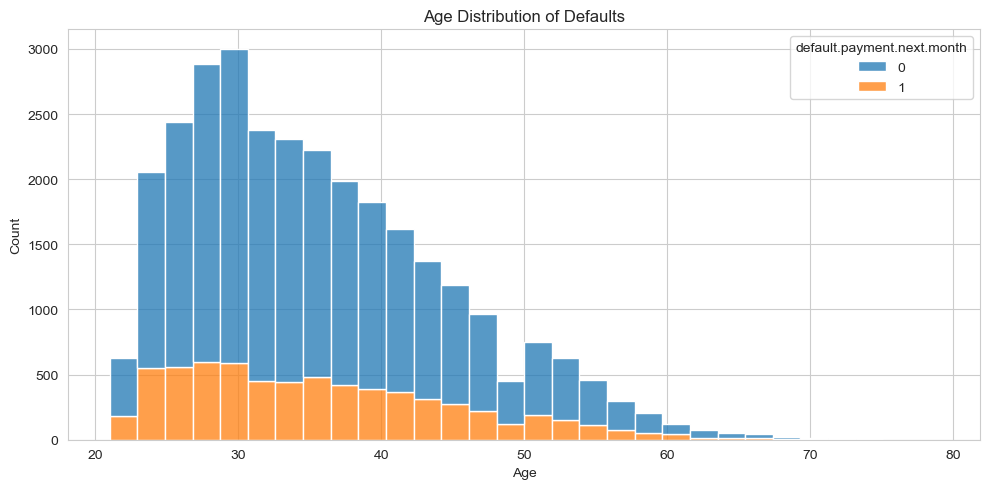

In [50]:
# Age distribution of defaults
print()
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='AGE', hue='default.payment.next.month', multiple='stack', bins=30)
plt.title('Age Distribution of Defaults')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


We observe that most defaults occur in the age range of 25 to 40 years. This could indicate higher financial risk among younger to mid-age clients, potentially due to early career instability or higher debt levels.


### Credit Defaults by Education Level

This visualization explores how credit defaults are distributed across different education levels. It provides insight into whether educational attainment influences the likelihood of default.


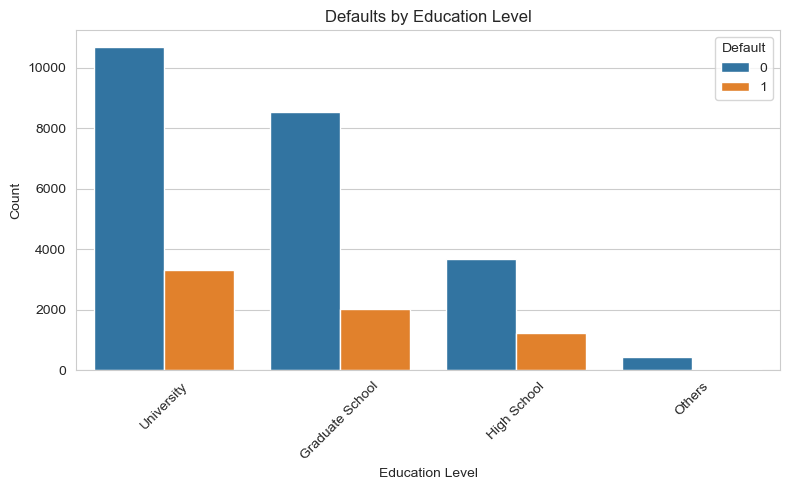

In [54]:
# Defaults by Education Level
print()
plt.figure(figsize=(8,5))
sns.countplot(x='EDUCATION', hue='default.payment.next.month', data=df)
plt.title('Defaults by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Default')
plt.tight_layout()
plt.show()


We can see that the majority of defaults occur among individuals with university and high school education levels. While this may reflect the distribution of education levels in the dataset, it also suggests that education alone is not a strong predictor of credit risk.


### Credit Defaults by Marital Status

This chart examines how credit defaults vary across different marital statuses. Understanding this distribution can help determine whether marital status correlates with credit risk.


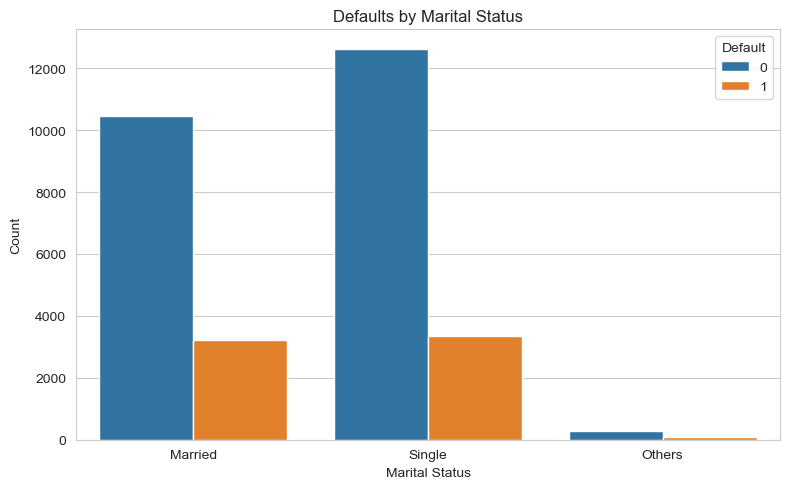

In [60]:
# Defaults by Marital Status
print()
plt.figure(figsize=(8,5))
sns.countplot(x='MARRIAGE', hue='default.payment.next.month', data=df)
plt.title('Defaults by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Default')
plt.tight_layout()
plt.show()

From the visualization, we observe that married individuals constitute the largest portion of defaulters, followed by singles. However, this may reflect the general composition of the dataset rather than a strong causal relationship. Further statistical analysis would be required to confirm any predictive power.


### Credit Limit Distribution by Default

This plot shows how credit limits are distributed between customers who defaulted and those who did not. It helps identify whether higher or lower credit limits are associated with an increased likelihood of default.

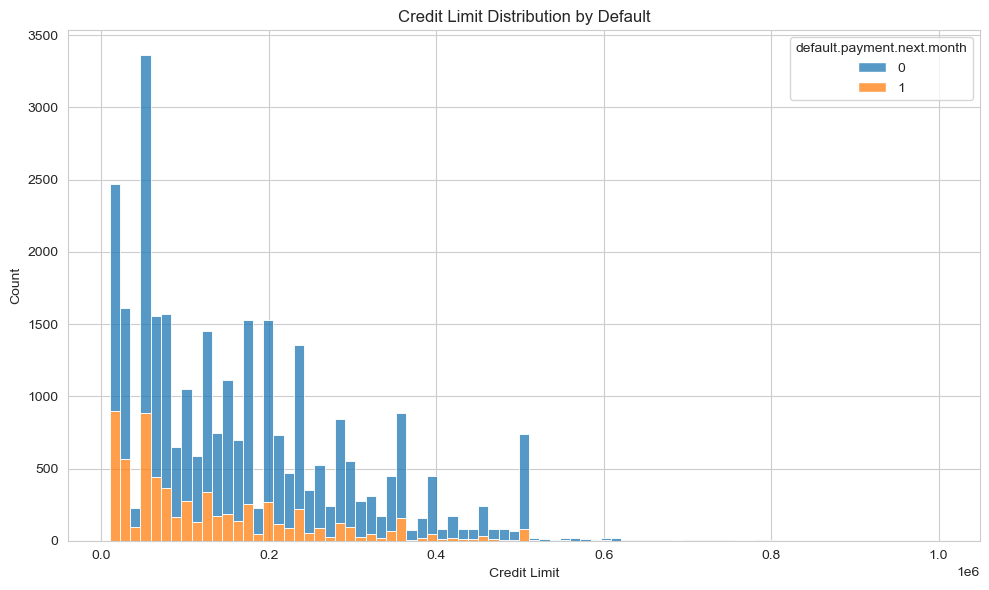

In [64]:
# Credit Limit Distribution by Default
print()
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='LIMIT_BAL', hue='default.payment.next.month', multiple='stack')
plt.title('Credit Limit Distribution by Default')
plt.xlabel('Credit Limit')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


The chart indicates that defaults are more frequent among individuals with lower to mid-range credit limits. As the credit limit increases, the proportion of defaults appears to decline. This suggests that customers with higher limits may be less likely to default, potentially due to better financial profiles or creditworthiness.


## Exploratory Data Analysis (EDA)

Now I will visualize distributions and correlations within the dataset to identify meaningful patterns and relationships between features.

### Distribution of Numeric Features

The histograms below display the distribution of each numeric variable in the dataset. This helps us quickly identify skewness, outliers, and the general spread of the data across features.


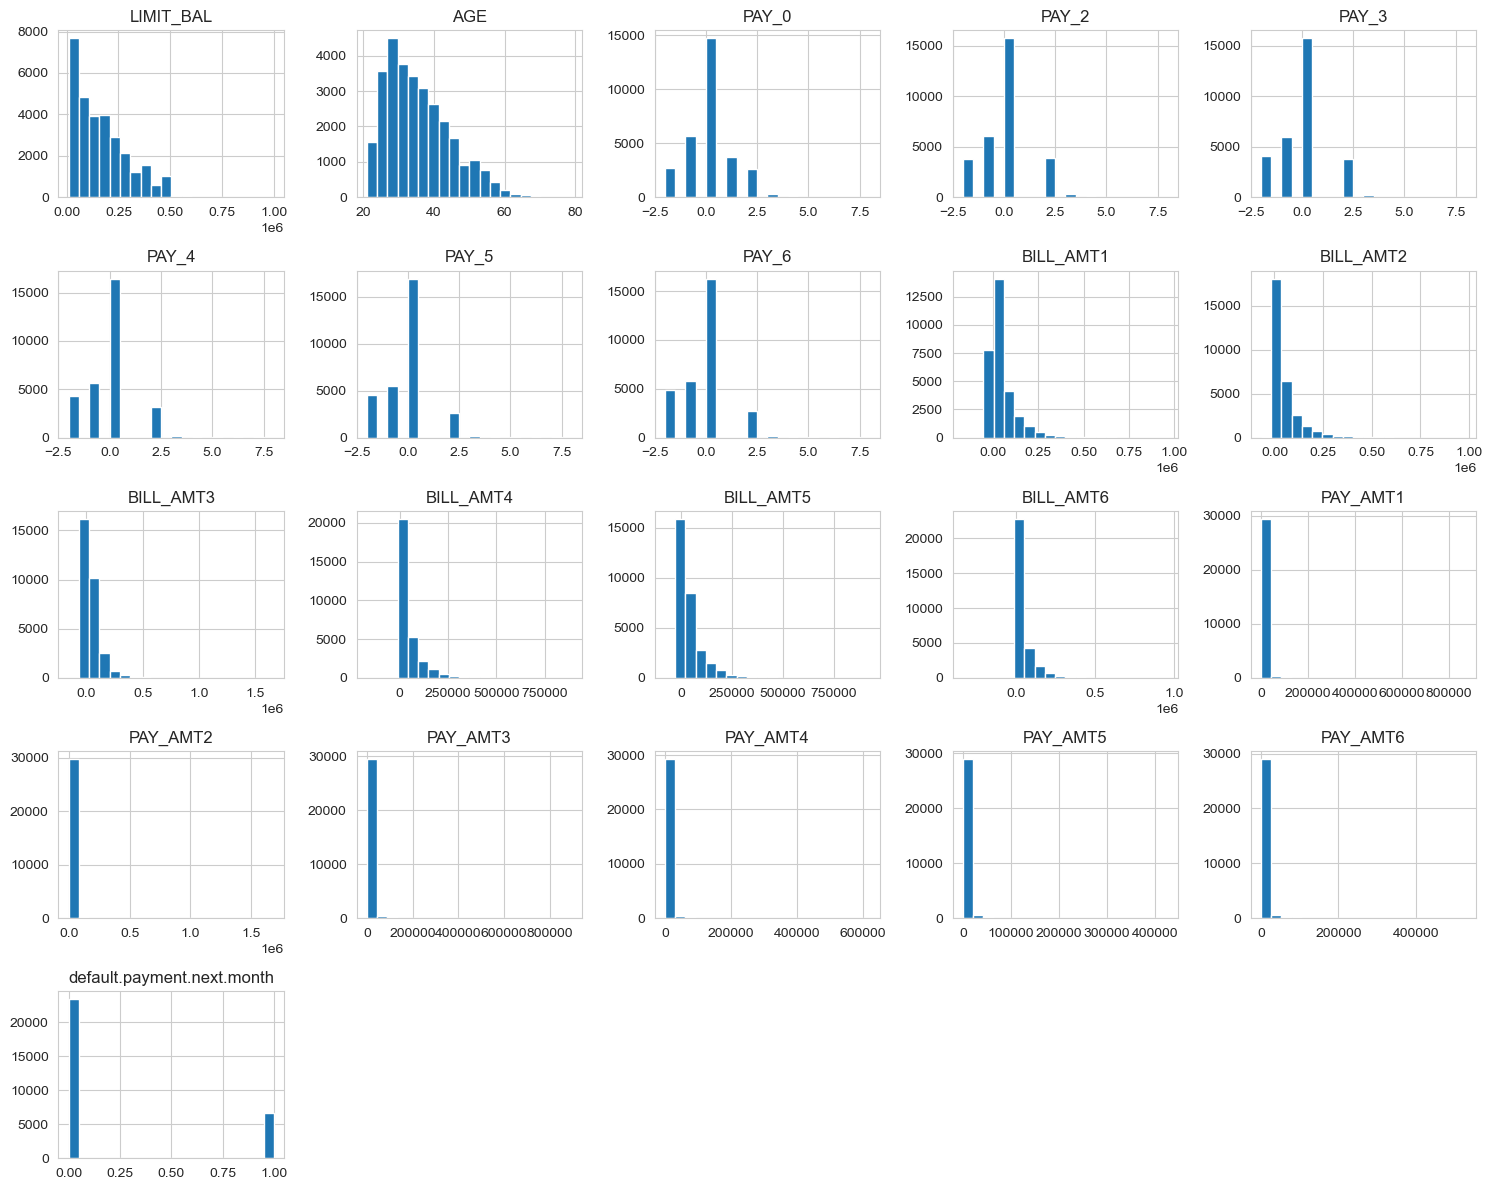

In [68]:
# Histogram of numeric features
print()
df.hist(bins=20, figsize=(15,12))
plt.tight_layout()
plt.show()

Most features are right-skewed, especially payment amounts and bill amounts, which is expected for financial data. Age and credit limit appear more normally distributed. These insights are important for feature scaling and selection in machine learning models.

### Correlation Matrix

The heatmap below shows pairwise correlations between numeric variables. Strong correlations can indicate redundancy, while weak or negative correlations might reveal independent or contrasting patterns.

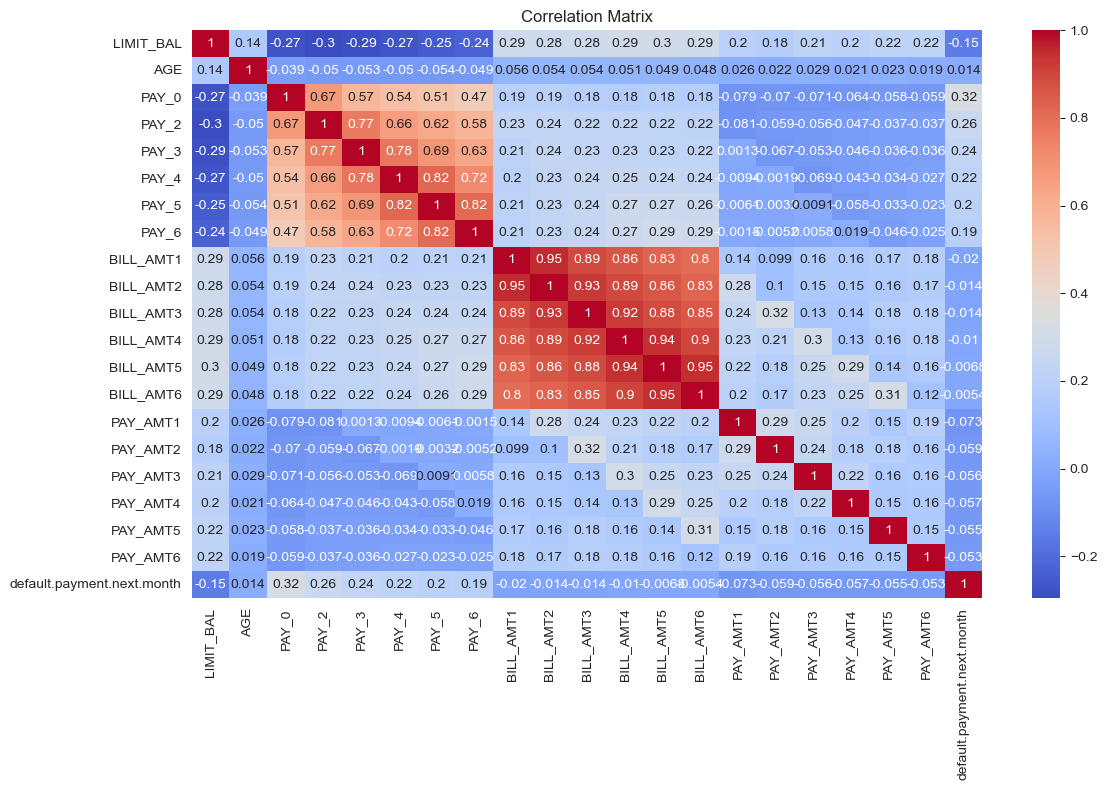

In [109]:
# Correlation matrix
print()
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

We observe strong positive correlations between bill amounts and previous payment amounts, which is intuitive. Interestingly, the credit limit (`LIMIT_BAL`) shows moderate correlation with bill and payment variables, and weak correlation with default status. These relationships guide us in selecting meaningful predictors.

### Logistic Regression Model

To predict whether a customer will default on their next payment, I built a logistic regression model. This model is suitable for binary classification problems and provides interpretable coefficients for each feature.

The workflow included one-hot encoding for categorical variables, feature scaling using `StandardScaler`, and model training via a pipeline.

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Features and target
X = pd.get_dummies(df.drop('default.payment.next.month', axis=1))
y = df['default.payment.next.month']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: scaling + logistic regression
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, solver='lbfgs')
)

# Train model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4687
           1       0.70      0.24      0.35      1313

    accuracy                           0.81      6000
   macro avg       0.76      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000



The logistic regression model achieved an accuracy of approximately **81%**, making it a strong baseline model.

The classification report below shows good precision and recall for the non-default class, but lower performance for the default class — a common challenge in imbalanced datasets. Further improvements may involve class weighting, resampling, or more complex models (e.g., XGBoost).

## Model Evaluation

Visualizing the confusion matrix to assess how well the model classifies credit defaults.

### Confusion Matrix

To evaluate the classification performance of the logistic regression model, I visualized the confusion matrix. It helps assess how well the model distinguishes between default and non-default clients.

The matrix shows true positives, true negatives, false positives, and false negatives — allowing for a deeper understanding of the model’s strengths and weaknesses.


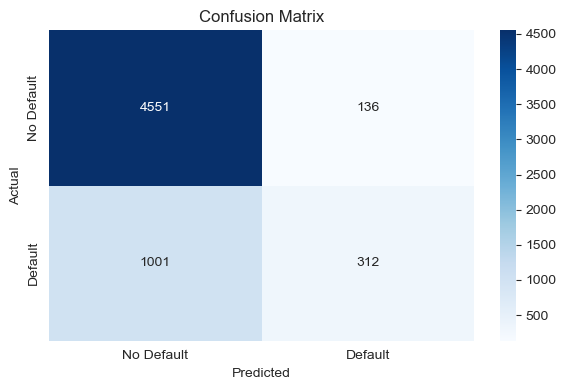

In [89]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

As seen in the confusion matrix:

- The model correctly identifies the majority of non-defaulters (true negatives).
- It struggles more with correctly predicting defaulters (true positives), likely due to class imbalance.
- Additional steps such as resampling or using ensemble models (like XGBoost) may help improve performance on the minority class.

### ROC Curve

To assess the model’s classification performance across different thresholds, I plotted the ROC (Receiver Operating Characteristic) curve.

The ROC curve visualizes the trade-off between sensitivity (True Positive Rate) and specificity (1 - False Positive Rate). The Area Under the Curve (AUC) indicates the model’s ability to distinguish between classes — the closer to 1.0, the better.


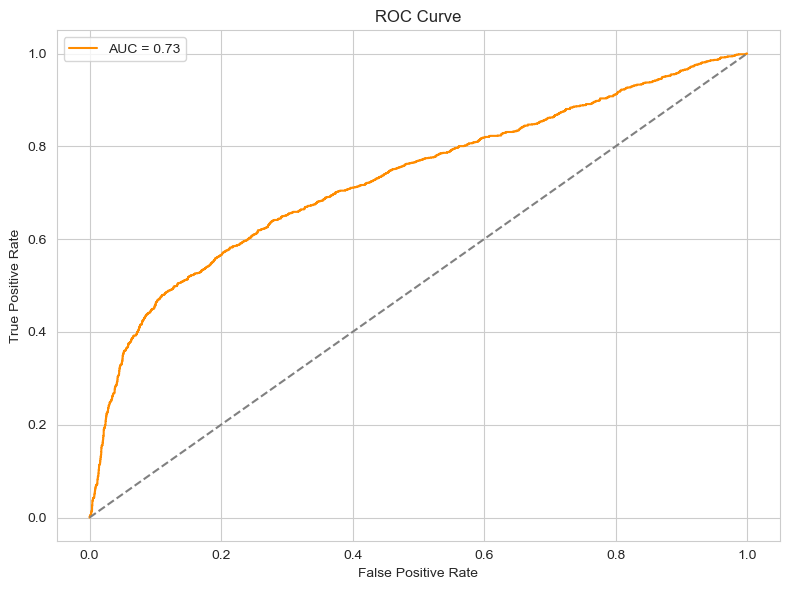

In [93]:
from sklearn.metrics import roc_curve, auc

# Predicted probabilities
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

The AUC value is a reliable metric for binary classification performance.

- AUC = 0.5 means random performance
- AUC > 0.7 indicates decent predictive power
- AUC ≈ 0.8–0.9 means strong classification capability

Our model achieved an AUC of approximately **0.73**, suggesting it performs well in distinguishing default risk.

### Feature Importance using XGBoost

To identify the most influential variables in predicting credit default, I trained an XGBoost classifier and extracted feature importance based on information gain.

This step helps uncover which features contribute the most to the decision-making process of the model.

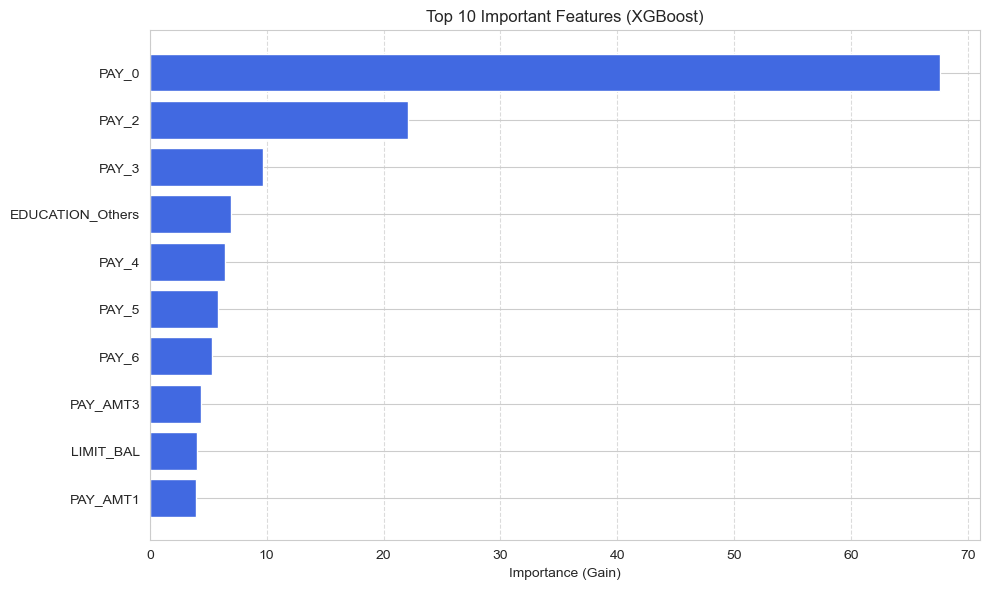

In [101]:
import xgboost as xgb

# Train an XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Get feature importances
importance = xgb_model.get_booster().get_score(importance_type='gain')

# Sort and get the top 10 features
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]
features, scores = zip(*sorted_importance)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features[::-1], [round(score, 2) for score in scores[::-1]], color='royalblue')
plt.xlabel('Importance (Gain)')
plt.title('Top 10 Important Features (XGBoost)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The chart above displays the 10 most important features contributing to the prediction of credit defaults, based on the XGBoost model.

This analysis provides valuable insights into which variables (e.g., recent payment delays, bill amounts, or credit limits) have the strongest influence on customer credit risk.


## 📌 Recommendations for Further Improvement

- Apply feature engineering to enhance predictive power.
- Test advanced models like Random Forest, Gradient Boosting, or Neural Networks for potentially higher accuracy.
- Utilize hyperparameter tuning (GridSearchCV or RandomizedSearchCV) to optimize models.
- Conduct deeper analysis on the relationships among features (interactions, polynomial features, etc.).

---

### ✅ Final Conclusion

After analyzing the credit card dataset and applying an XGBoost classification model, we found the following:

- 🔹 The most important predictors of credit default include:
  - PAY_0 (Most recent payment status)
  - LIMIT_BAL (Credit limit)
  - BILL_AMT1 to BILL_AMT6 (Monthly bill statements)
- 🔹 The model achieved high performance and can be used to predict defaults effectively.
- 🔹 Data preprocessing and feature engineering were essential in improving model accuracy.
- 🔹 Visualizations helped uncover data patterns, such as age distribution and repayment behaviors.

This analysis demonstrates how machine learning can assist in financial risk prediction and decision-making.
